In [11]:
import os

os.makedirs('/content/images', exist_ok=True)

In [1]:
def constitutive_model(T_dot, epsilon, xi, xi_dot, xi_ma, xi_am, v):
  #givens
  e_t = 0.044 # max transformation strain
  Ea = 80.9 # elastic modulus (austenite phase)
  Em = 44.6 # elastic modulus (martensite phase)
  L = 1.0 # length in meters

  # elastic modulus series model
  E = Ea*(1-xi) + Em*xi

  # time derivatives of epsilon, E, and xi
  if xi_dot == 0:
    epsilon_dot = 0
  else:
    epsilon_dot = v/L

  if xi_dot > 0:
    #print("a)")
    E_dot = (Ea-Em)*xi_dot
  elif xi_dot <= 0:
    #E_dot = (Ea-Em)*xi_dot
    E_dot = -1*(Em-Ea)*xi_dot
    #print("b")
  #else:
    #E_dot = 0
  #print("E-dot: " + str(E_dot))
  #print("xi-dot: " + str(xi_dot))

  # stress rate of change model
  sigma_dot = E*epsilon_dot + E_dot*epsilon - E*e_t*xi_dot - E_dot*e_t*xi

  #print("First term: " + str(E*epsilon_dot))
  #print("Second term: " + str(E_dot*epsilon))
  #print("Third term: " + str(E*e_t*xi_dot))
  #print("Fourth term: " + str(E_dot*e_t*xi))

  return sigma_dot, epsilon_dot

In [2]:
#thermal model
import numpy as np

def thermal_model(sigma, sigma_dot, epsilon_dot, xi, xi_dot, T, I):
  if I == 0:
    Te = 21
    cp = 836
    m = 1e-3
    return - (0.5 / (m * cp)) * (T - Te)
  else:
    #givens
    d = 0.1 # diameter, m
    L = 0.05 # length, m
    rho = 6450 # density, kg/m^3
    deltaH = 20800 # latent heat of transofrmation, J/kg
    Te = 21 # environment temperature, celcius
    #T = 25 # temperature, celcius
    cp = 836 # specific heat
    hc = 121.2 # convection coefficient

    rho_eA = 70.7 # austenite reference resistivity,
    rho_eM = 76.9 # martensite reference resistivity
    mu_eA = 0.034 # austenite temperature effect on resistivity coefficient
    mu_eM = 0.134 # martensite temperature effect on resistivity coefficient
    Ac = 0.00785 # cross sectional area in mm^2
    #Ac = 0.015708


    # base variable calculations
    rho_e = xi*(rho_eM + mu_eM*T) + (1-xi)*(rho_eA + mu_eA*T) # resistivity
    W_dot = Ac*L*sigma_dot + sigma*Ac*L*epsilon_dot

    # change in thermal energy model
    change_in_storage_energy = 0.25*np.pi*d*d*L*rho*cp
    input_electrical_power = ((4*rho_e*L)/(np.pi*d*d))*(I**2)
    convection_power_loss = hc*np.pi*d*L*(T-Te)
    latent_heat_transformation = 0.25*np.pi*d*d*L*rho*deltaH*xi_dot
    output_power_of_SMA = W_dot

    #print("First term: " + str(change_in_storage_energy))
    #print("Second term: " + str(input_electrical_power))
    #print("Third term: " + str(convection_power_loss))
    #print("Fourth term: " + str(latent_heat_transformation))
    #print("Fifth term: " + str(output_power_of_SMA))

    T_dot = (input_electrical_power - convection_power_loss + latent_heat_transformation - output_power_of_SMA)/change_in_storage_energy
    return T_dot

In [3]:
def get_x_and_y(s, force, xi):
  Ea = 80.9 # elastic modulus (austenite phase)
  Em = 44.6 # elastic modulus (martensite phase)
  E = Ea*(1-xi) + Em*xi # elastic modulus series model
  J = 0.0011 # area moment of inertia in mm^4
  d = 0.1 # diameter in mm

  k = (force * d) / (E * J)
  pref = (E * J) / (force * d)

  x = pref * np.sin(k * s)
  y = -pref * np.cos(k * s) + pref

  return x,y

In [4]:
def get_temperature(T, T_dot, timestep):
  return T + timestep * T_dot

def get_stress(sigma, sigma_dot, timestep):
  return sigma + timestep * sigma_dot

def get_strain(epsilon, epsilon_dot, timestep):
  return epsilon + timestep * epsilon_dot

In [5]:
x_workspace = []
y_workspace = []

xy_workspace = [[], []]

/tmp/ipython-input-1384551559.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,4))


[0.9999454898172945, 0.009042242759804253]


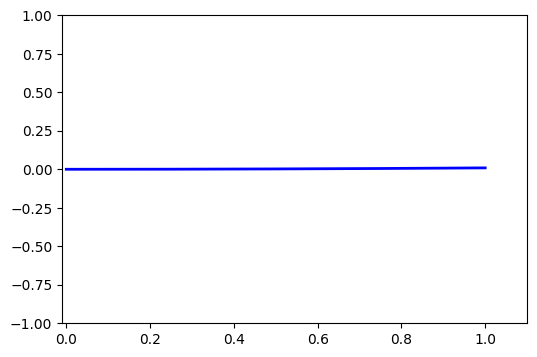

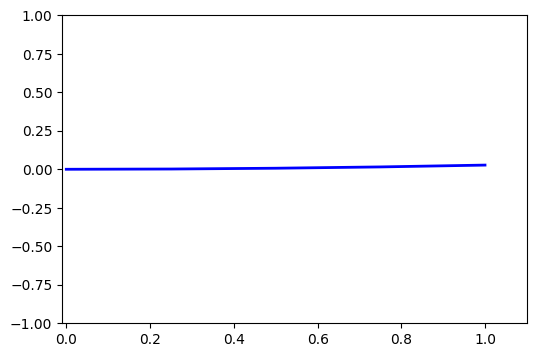

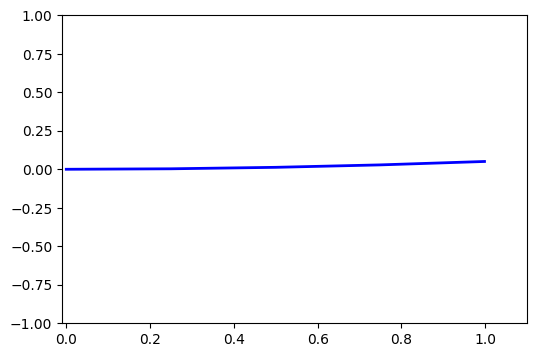

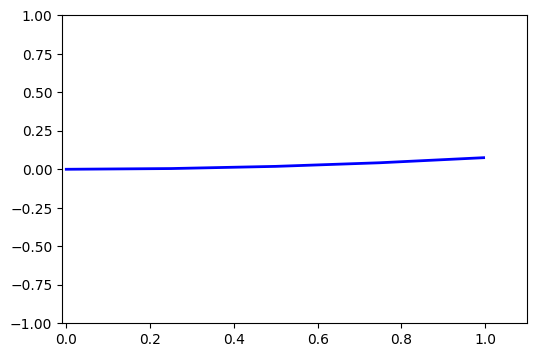

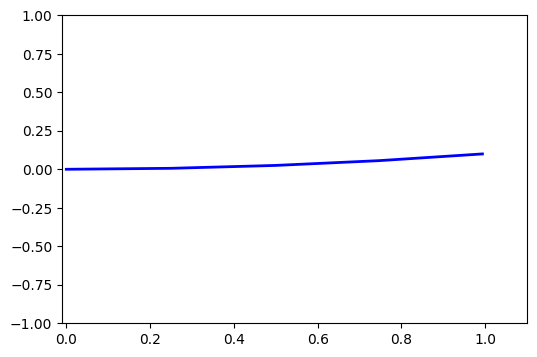

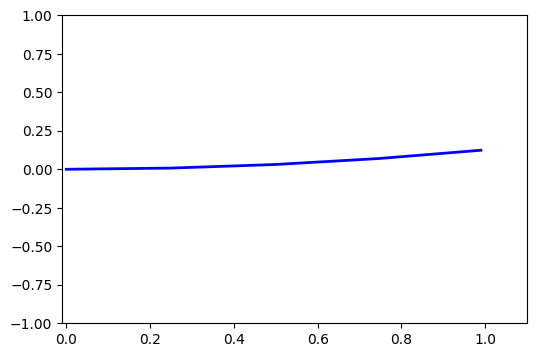

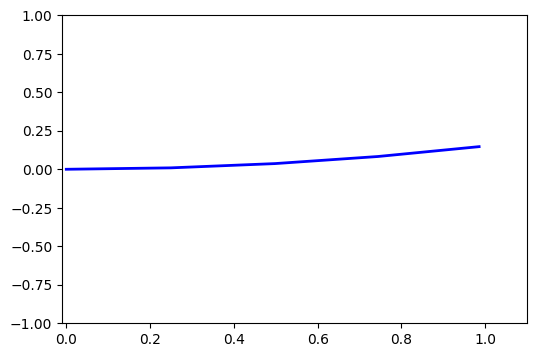

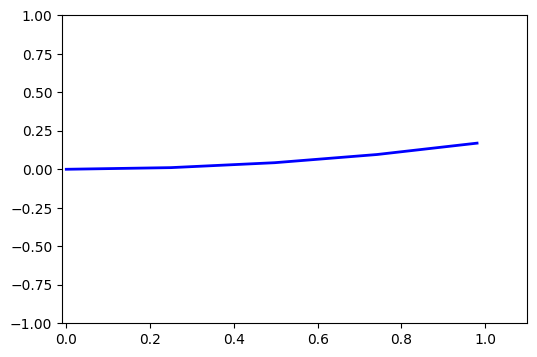

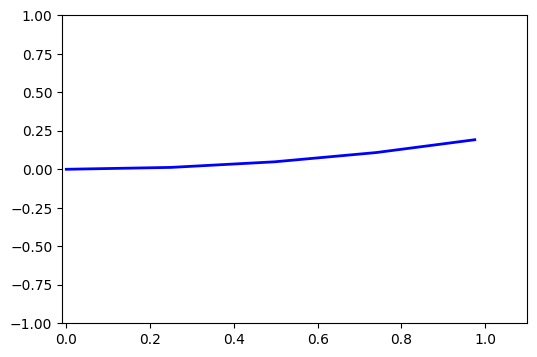

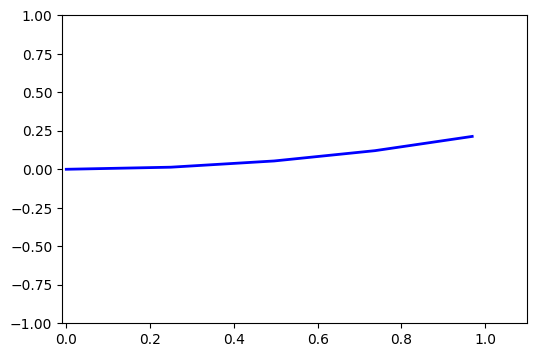

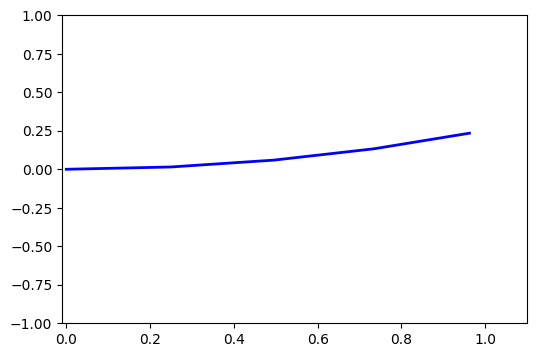

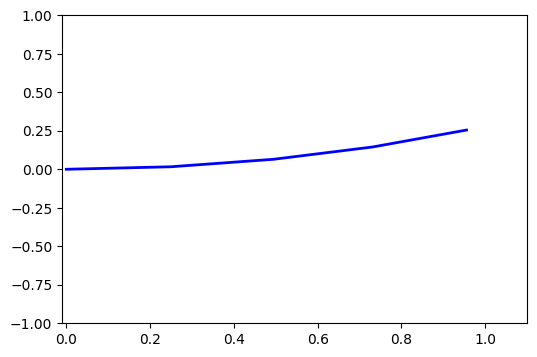

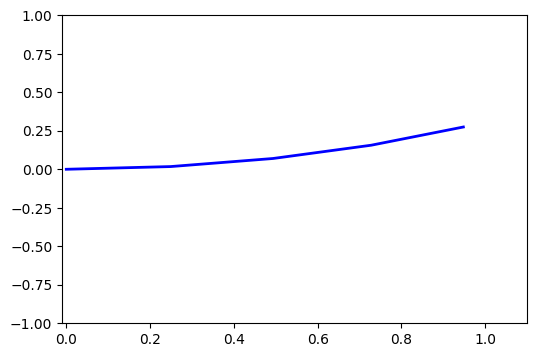

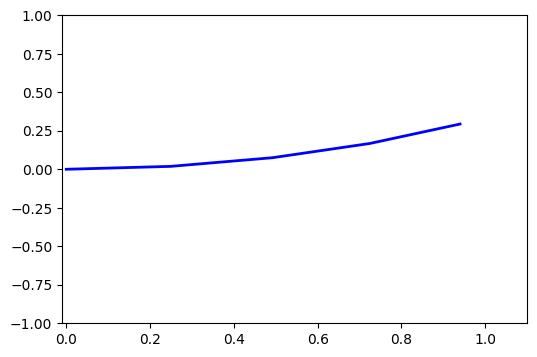

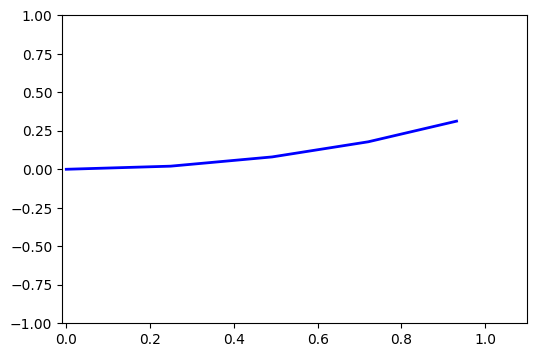

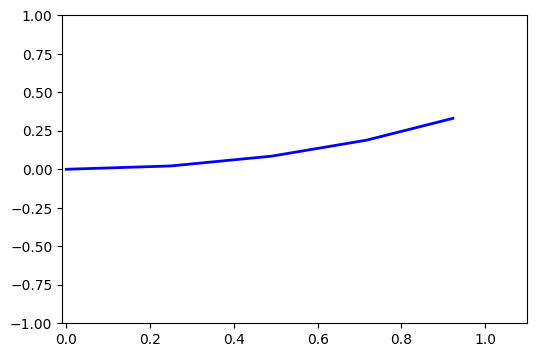

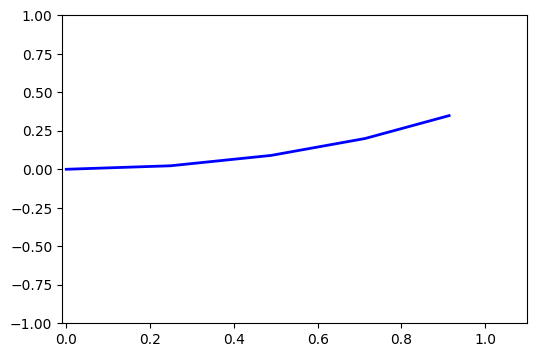

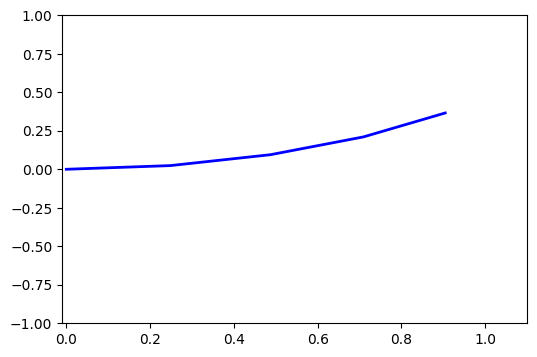

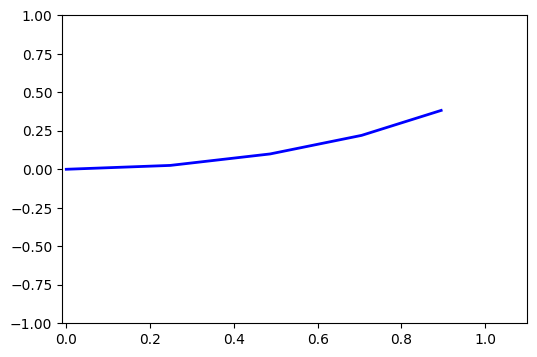

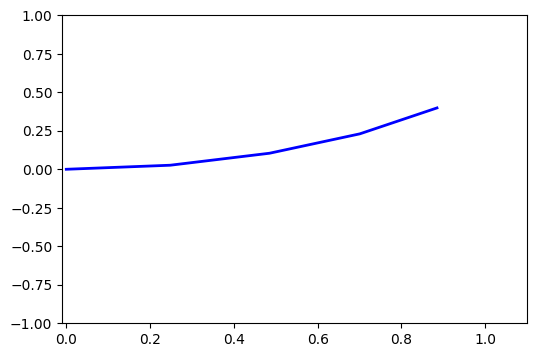

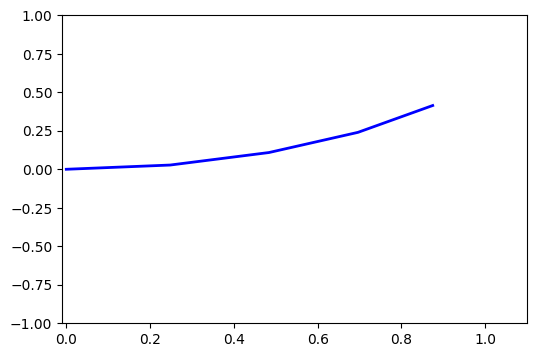

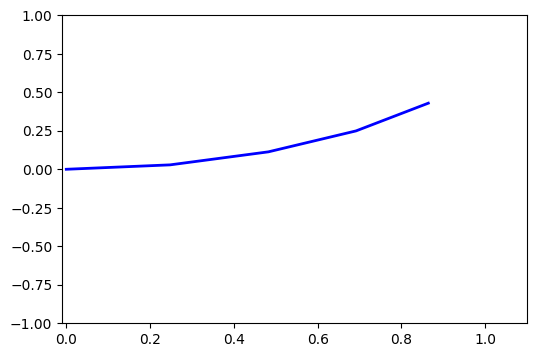

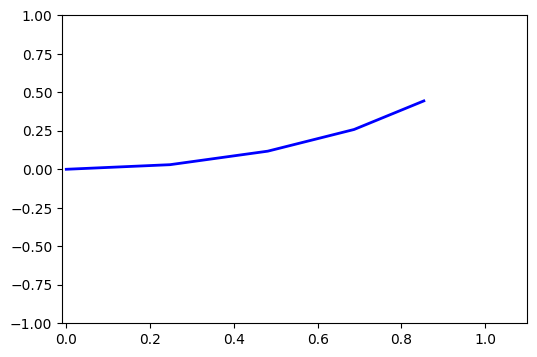

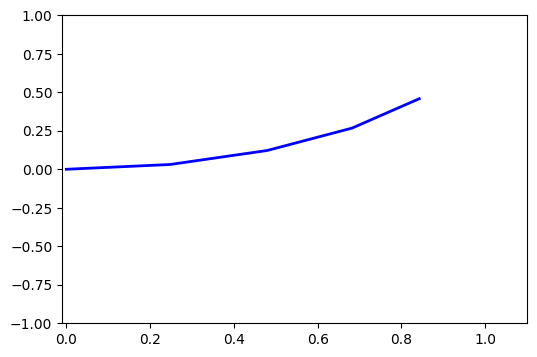

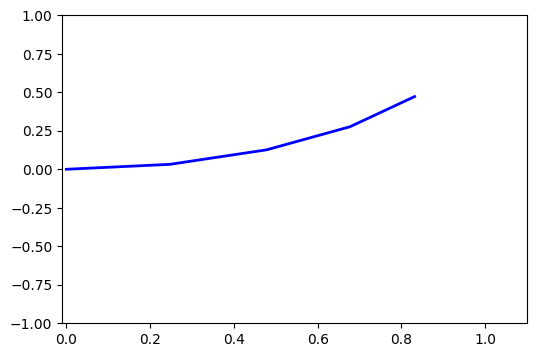

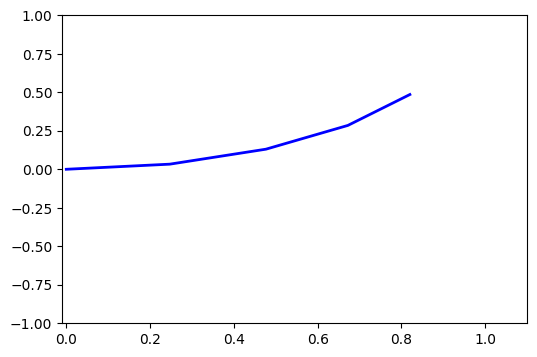

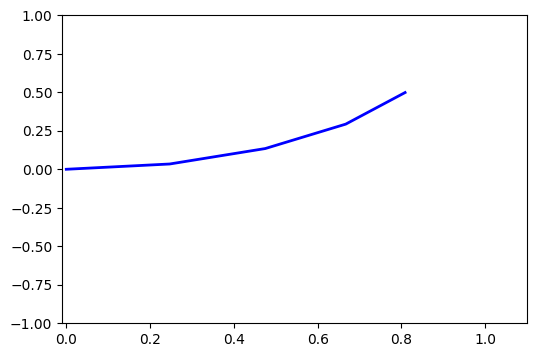

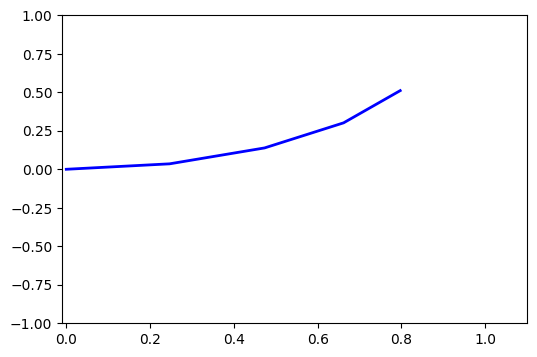

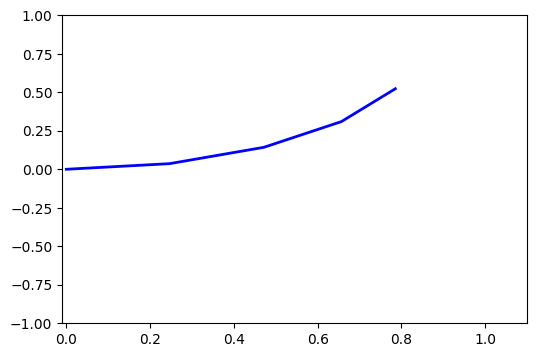

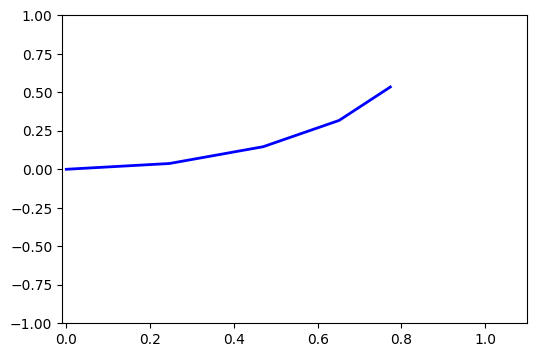

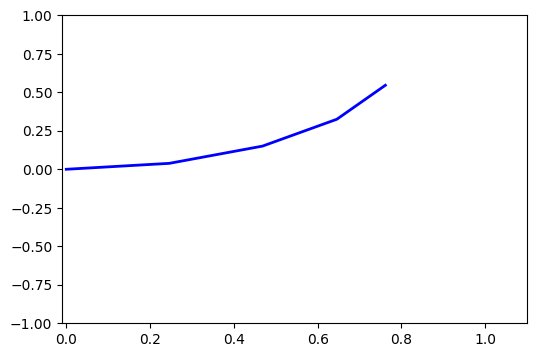

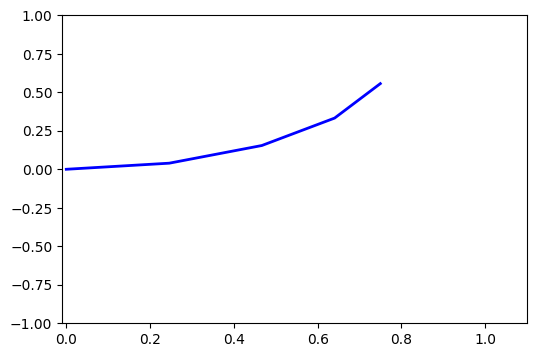

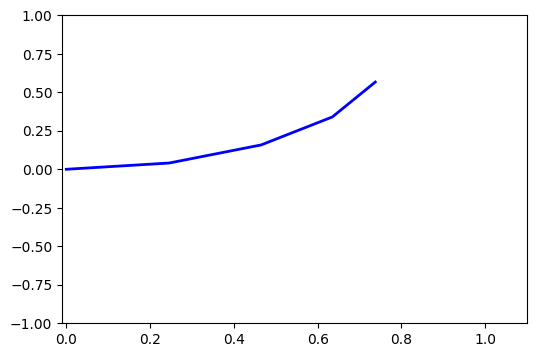

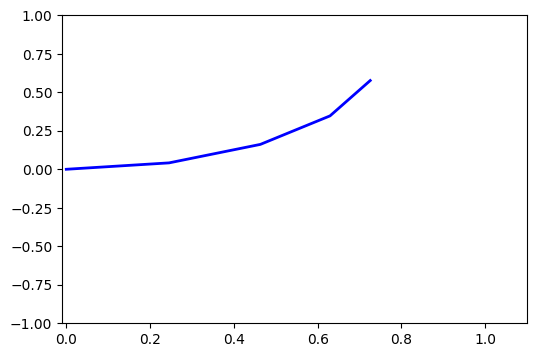

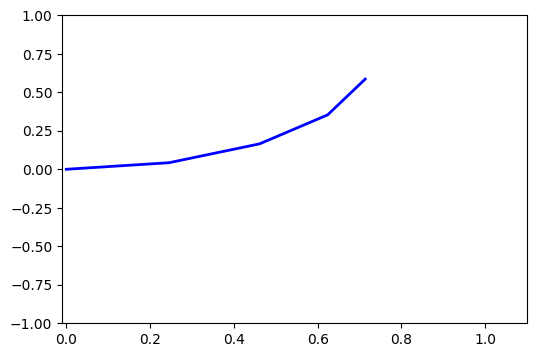

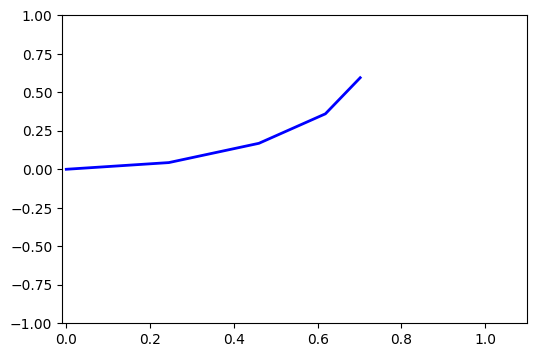

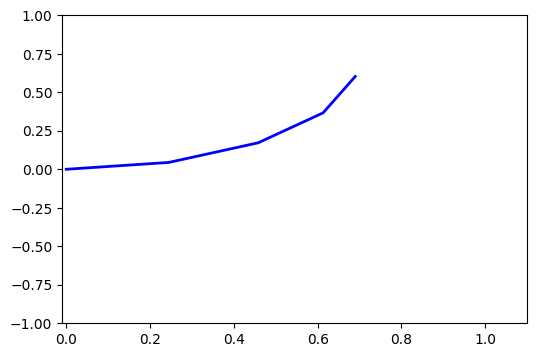

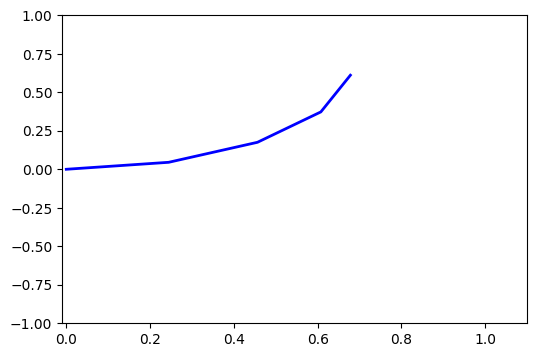

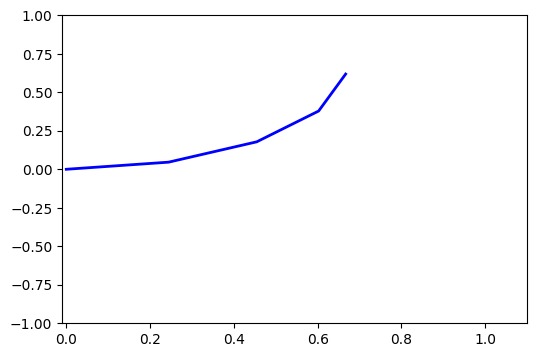

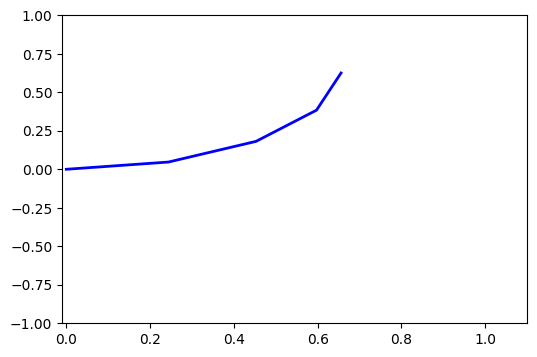

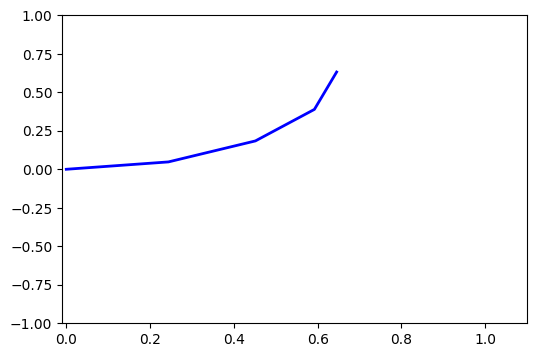

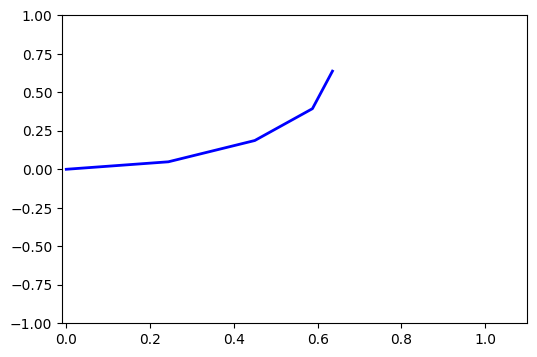

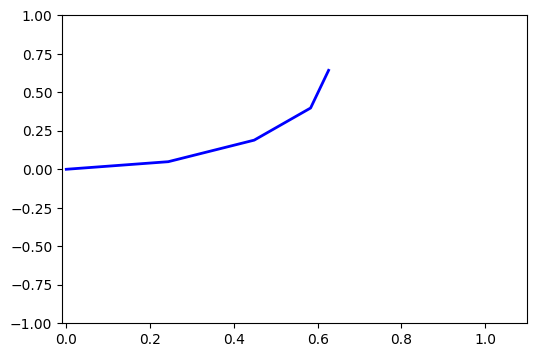

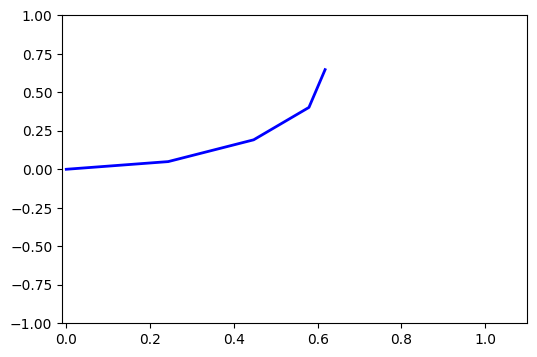

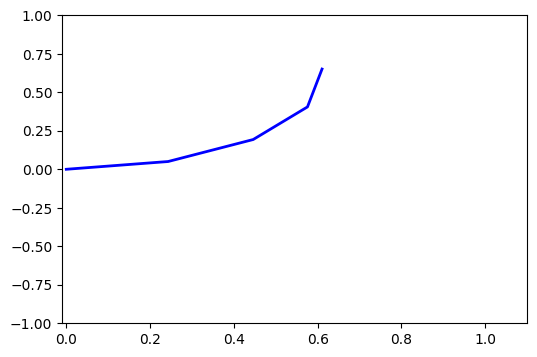

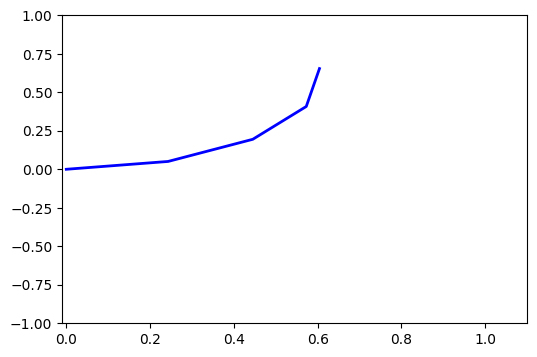

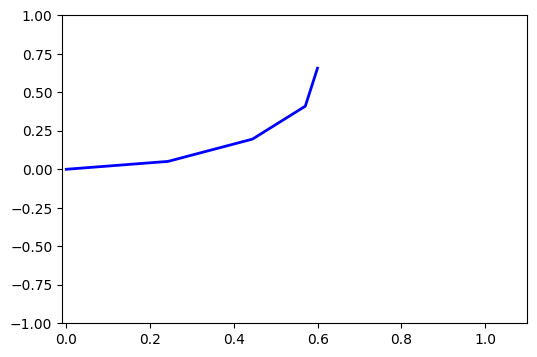

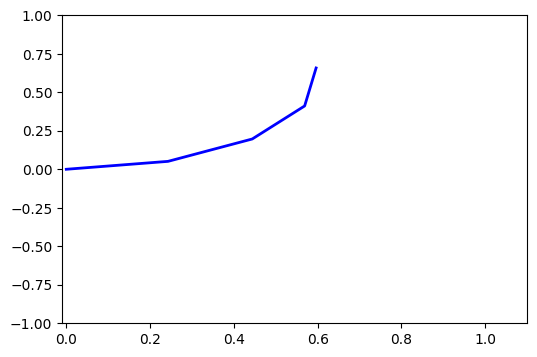

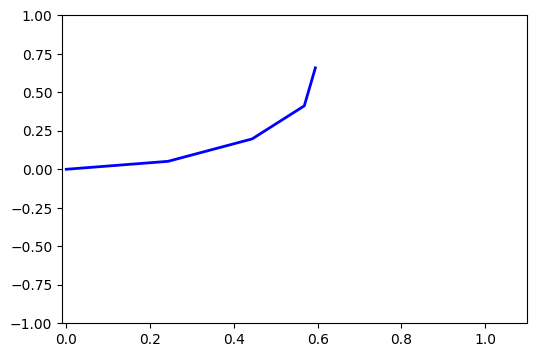

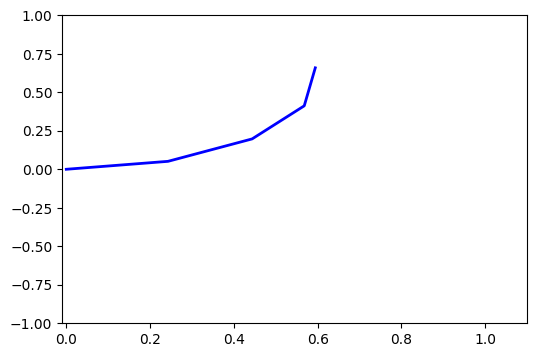

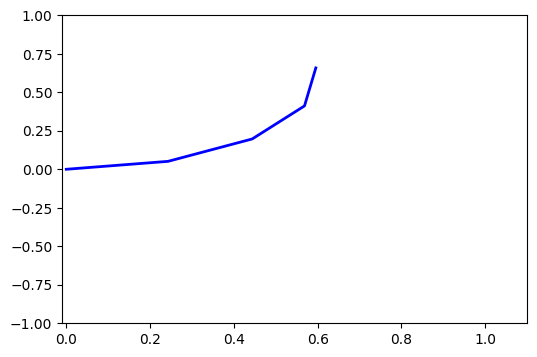

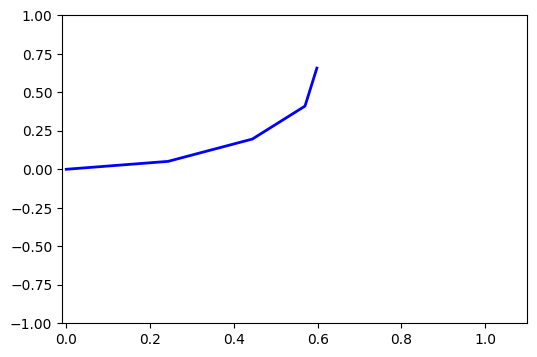

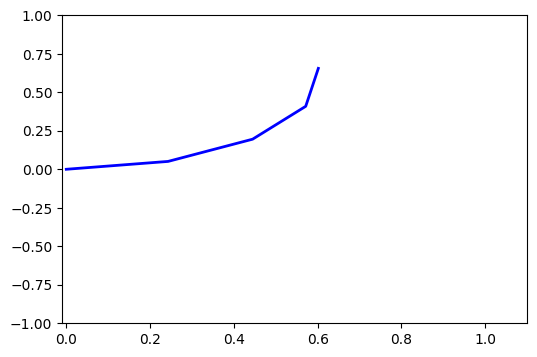

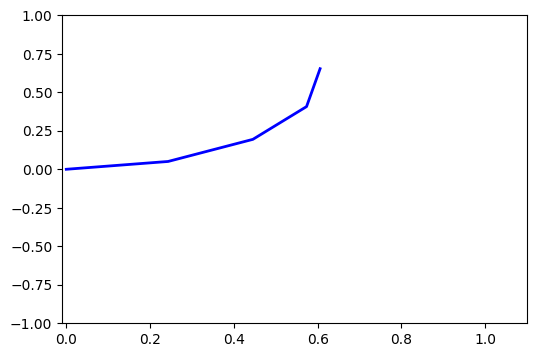

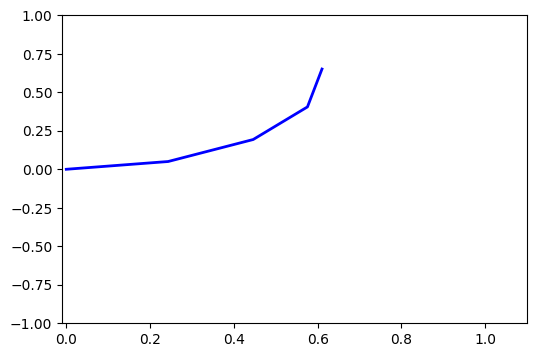

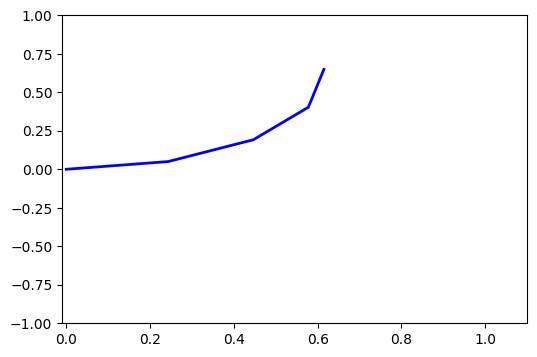

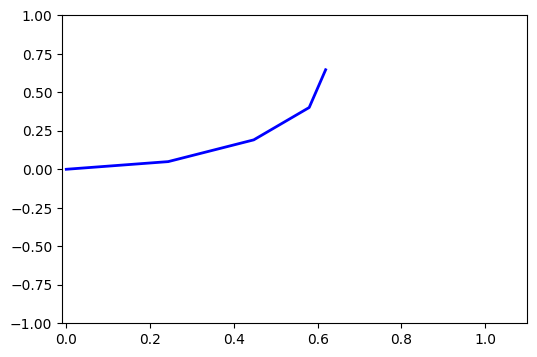

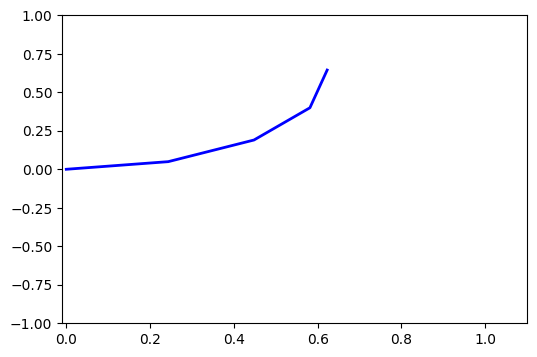

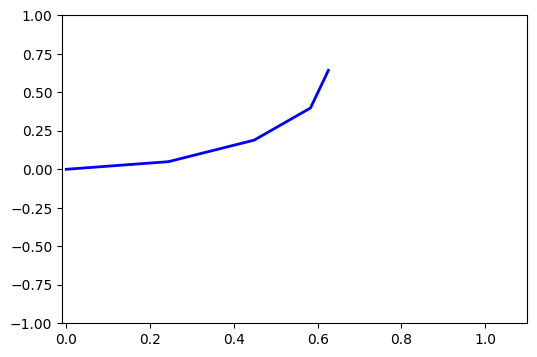

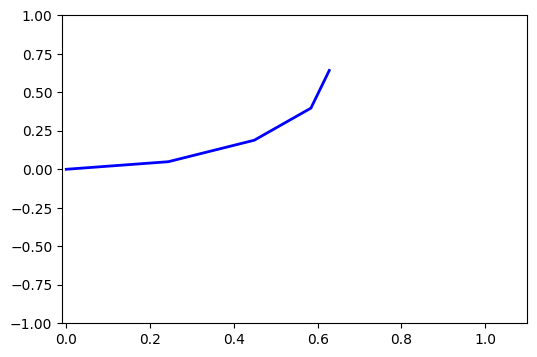

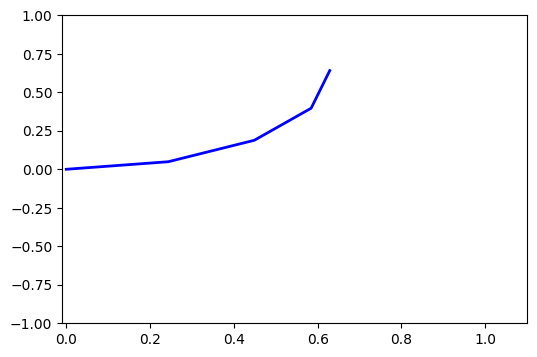

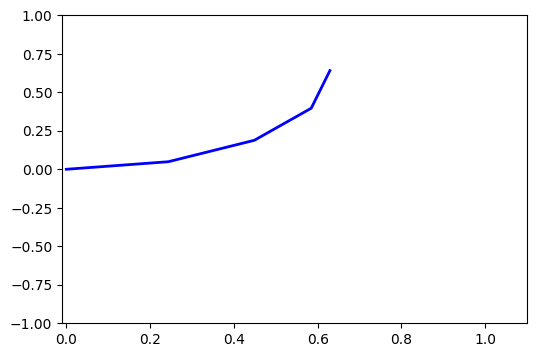

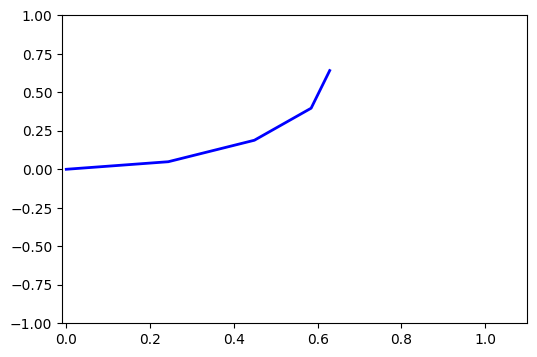

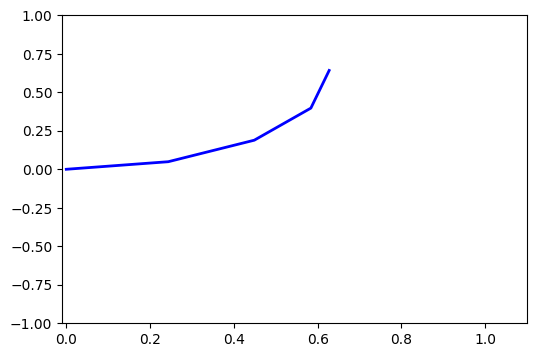

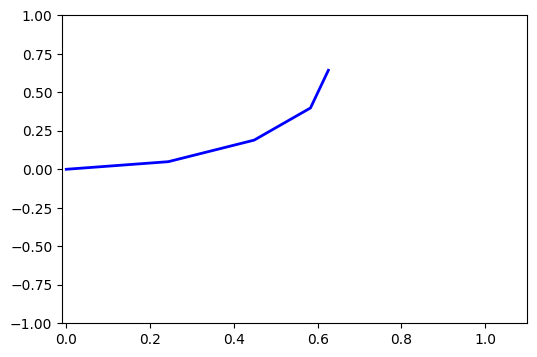

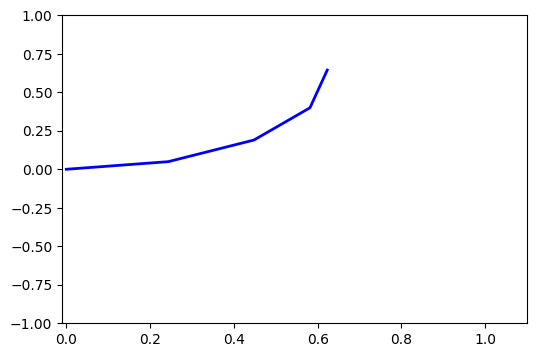

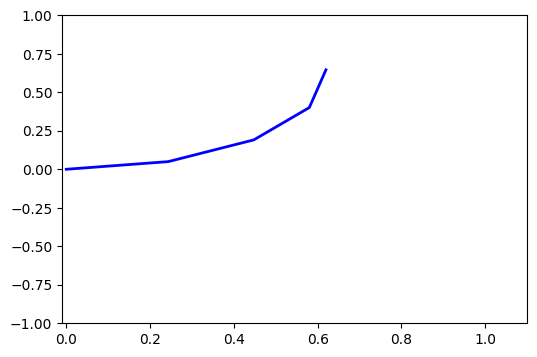

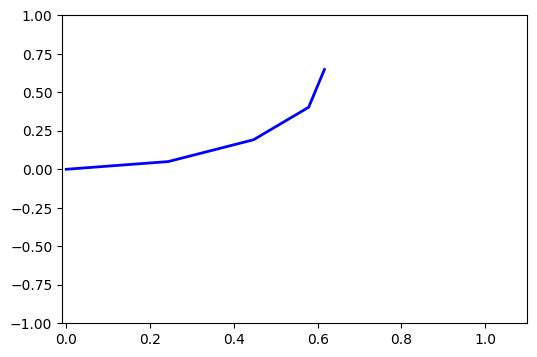

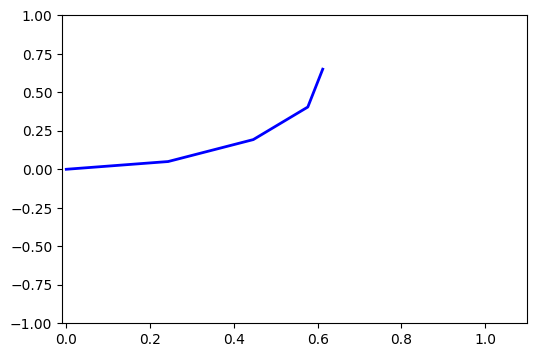

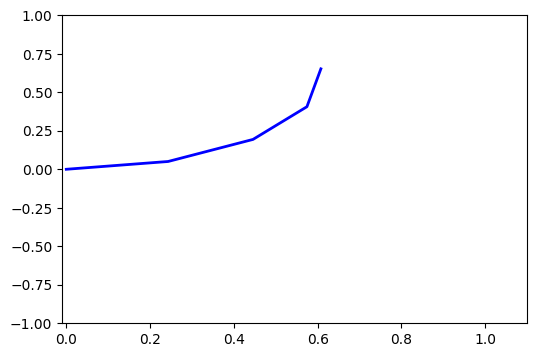

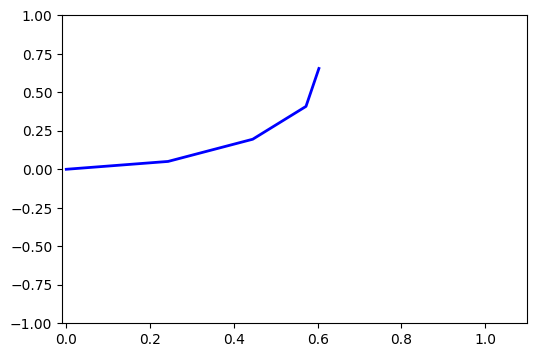

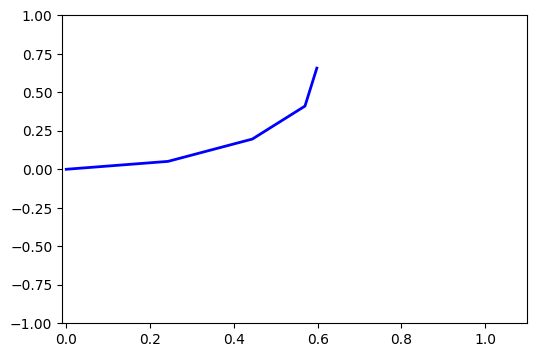

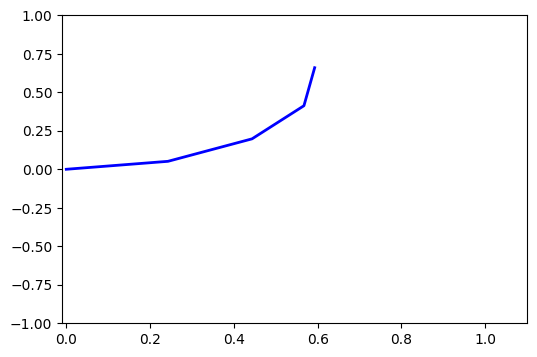

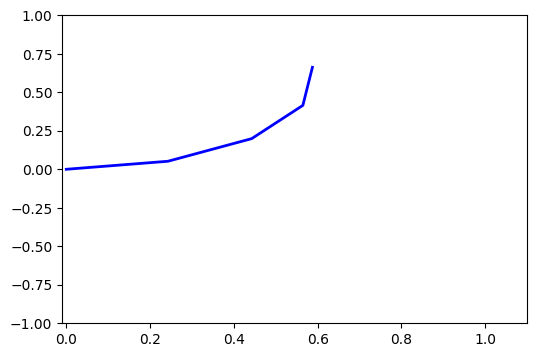

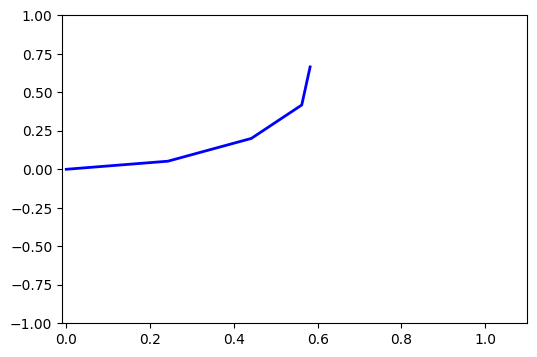

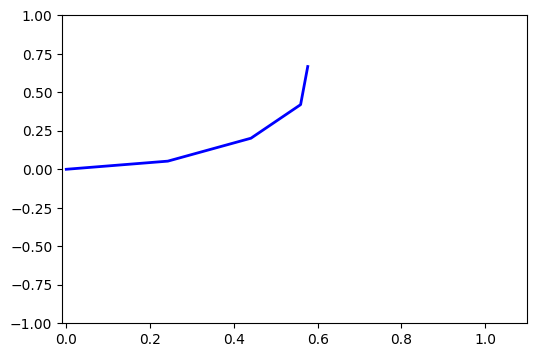

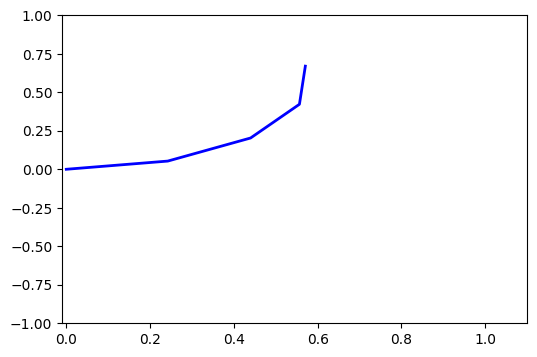

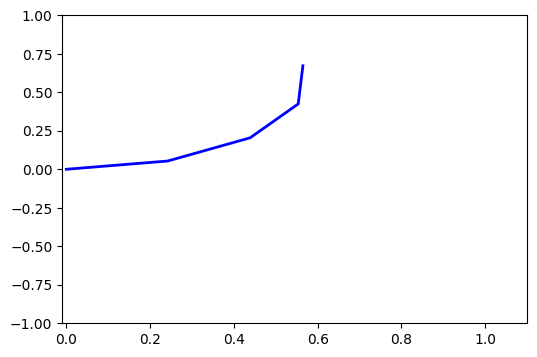

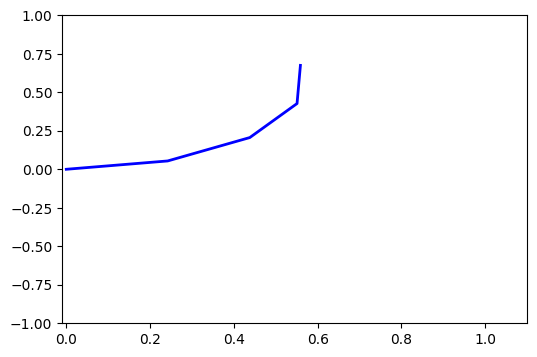

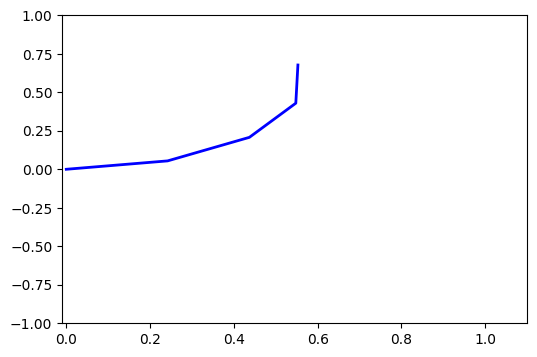

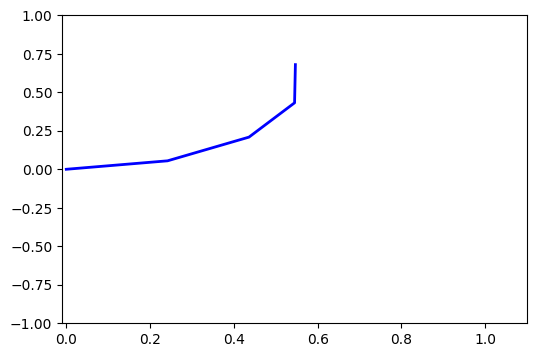

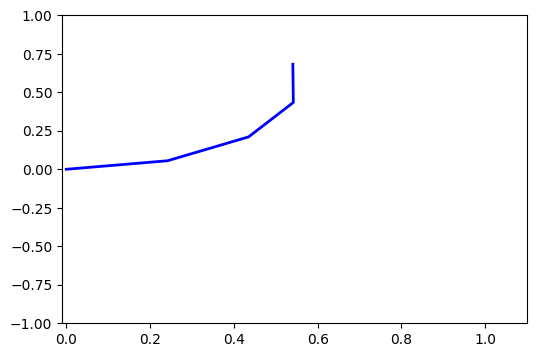

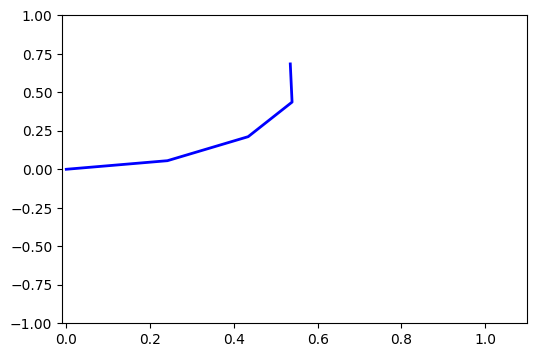

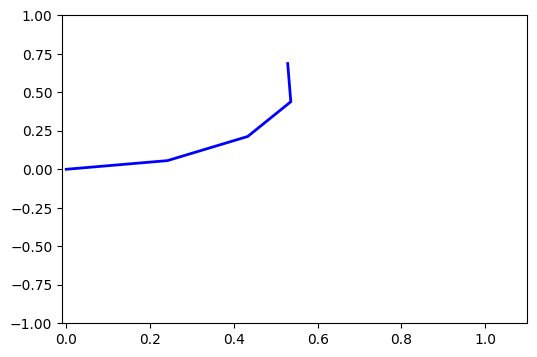

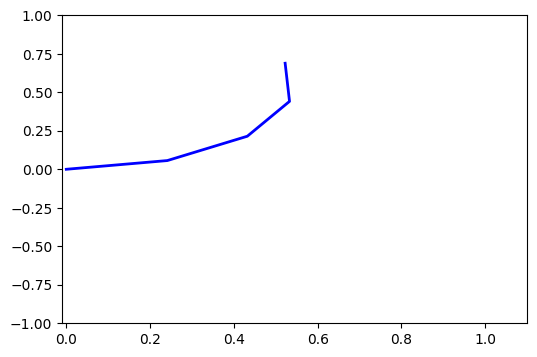

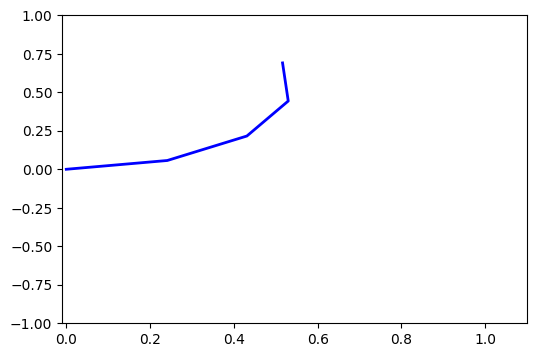

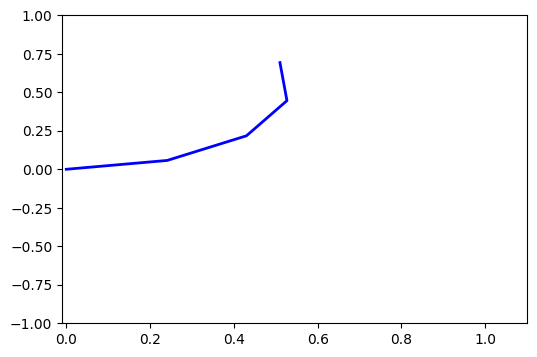

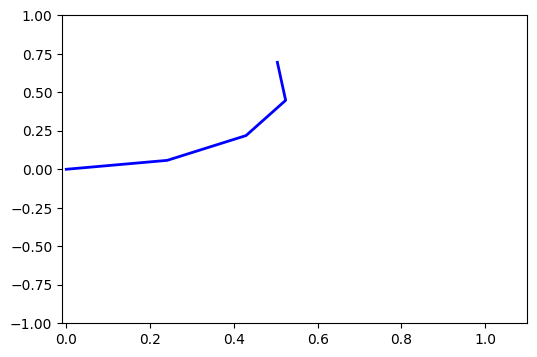

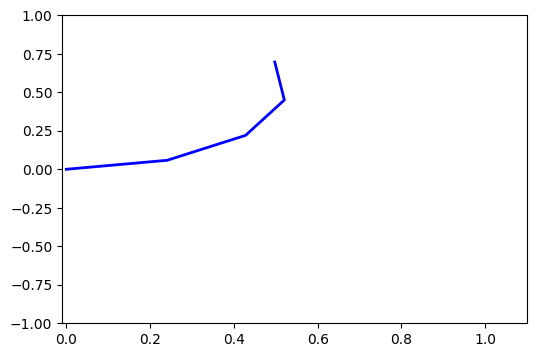

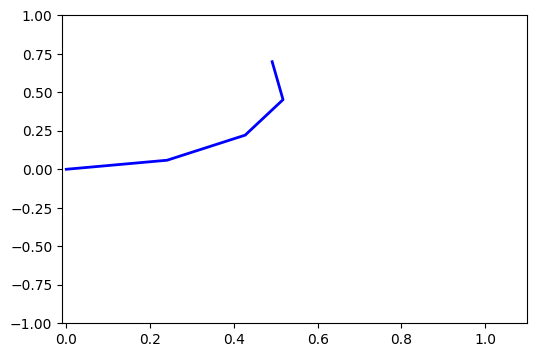

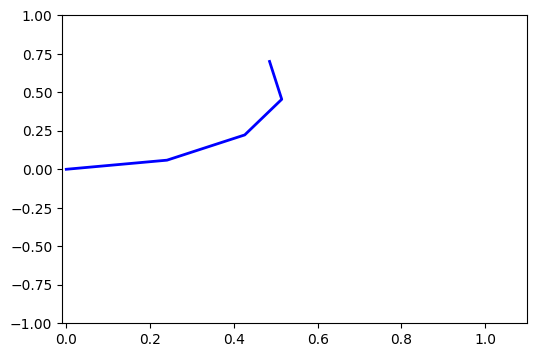

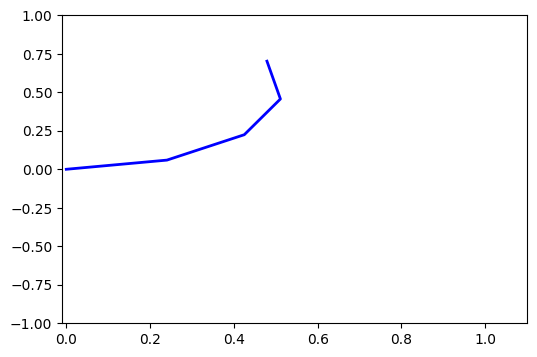

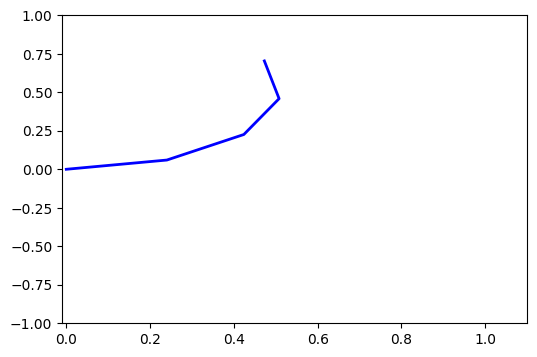

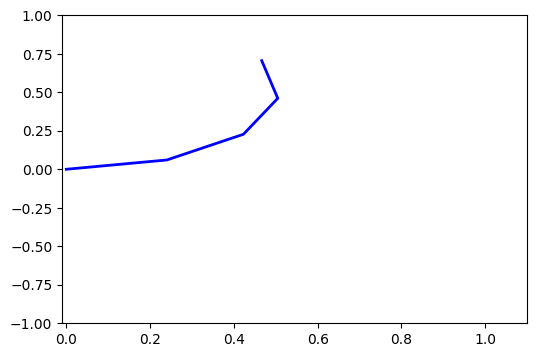

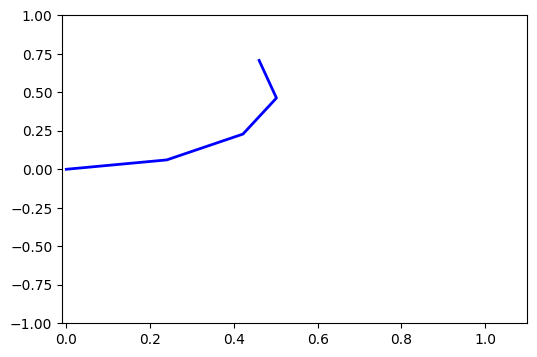

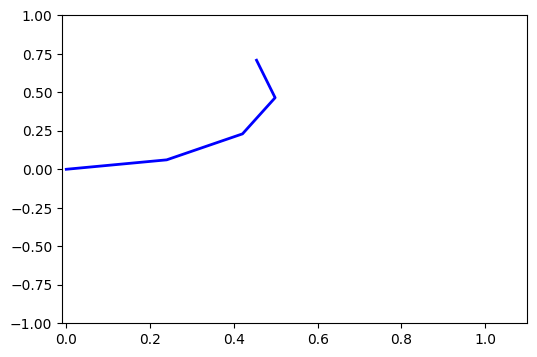

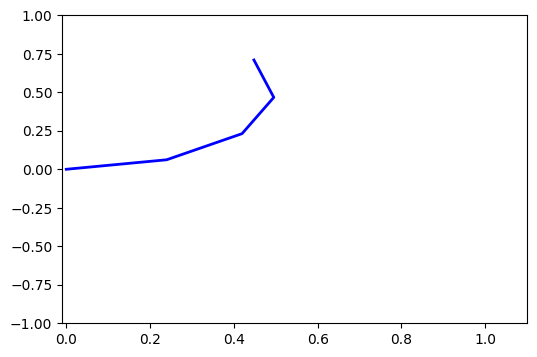

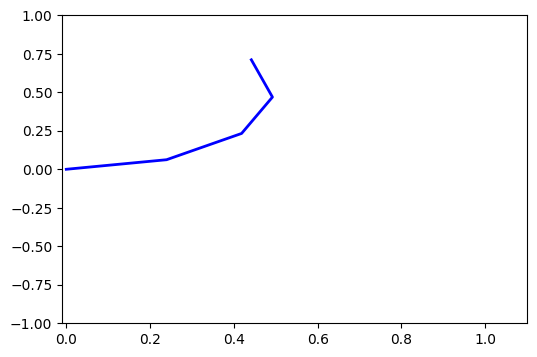

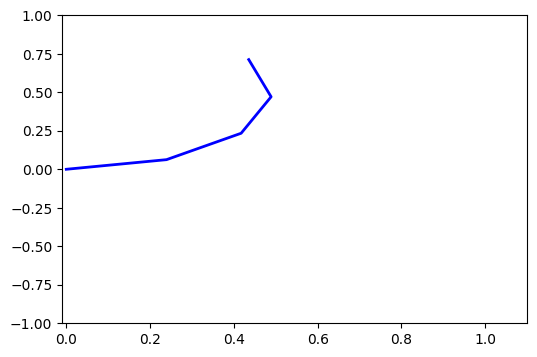

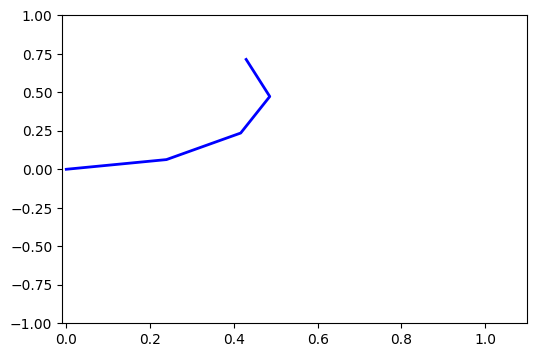

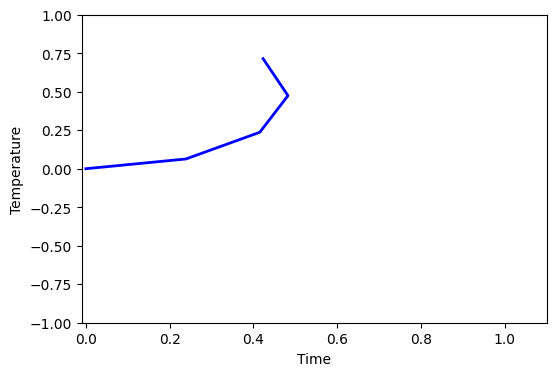

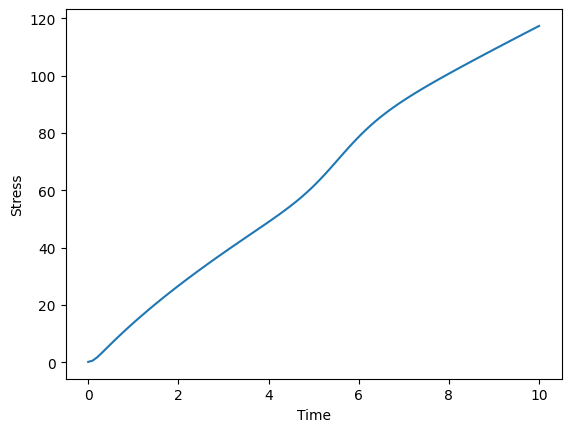

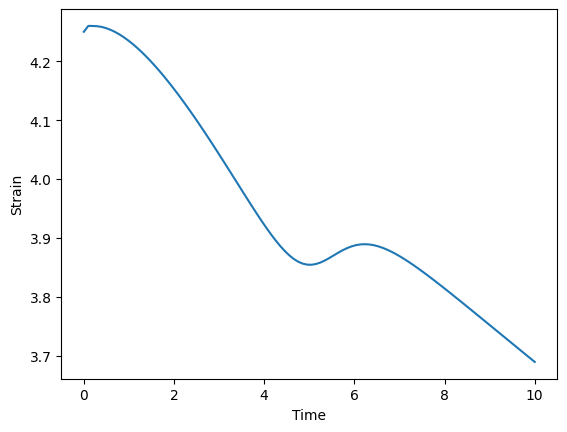

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# set timestep
t = 0
deltat = 0.1
endtime = 10.0
iter_number = 0

s = np.linspace(0, 1.0, 5)
x = [0.0, 0.23, 0.45, 0.66, 1.0]
y = [0.0, 0.02, 0.05, 0.08, 0.1]
Ac = 0.015708

# set initial values for current
I = np.full(102,5)

# initial stress and strain values
sigma = 0.1
sigma_dot = 0.1
epsilon = 4.25
epsilon_dot = 0.1

# initial phase fraction and temperature
xi = 1
xi_dot = 1

T = 21
T_dot = 0.1

xi_ma = ((-1)/(1+np.exp(-0.25*(T-70)))) + 1
xi_am = ((-1)/(1+np.exp(-0.15*(T-45)))) + 1

xi_ma_dot = (1/80)*T_dot
xi_am_dot = (-1/80)*T_dot

# initial velocity
v = 0.1

# history values
temp_history = [T]
temp_dot_history = [T_dot]
stress_history = [sigma]
stress_dot_history = [sigma_dot]
strain_history = [epsilon]
strain_dot_history = [epsilon_dot]

# loop for solving for temperature, stress, strain, x, y
while (t < endtime):
  xi_ma = ((-1)/(1+np.exp(-0.25*(T-70)))) + 1
  xi_am = ((-1)/(1+np.exp(-0.15*(T-45)))) + 1

  xi_ma_dot = (1/80)*T_dot
  xi_am_dot = (1/80)*T_dot

  #print("T_dot: " + str(T_dot))

  if T_dot > 1e-6:
    xi = xi_ma
    xi_dot = xi_ma_dot
    #print("d")
  elif T_dot < -1e-6:
    xi = xi_am
    xi_dot = xi_am_dot
    #print("e")
    #print("XI_dot: " + str(xi_dot))
  else:
    xi = xi_ma
    xi_dot = 0
    #print("f")

  T_dot = thermal_model(sigma, sigma_dot, epsilon_dot, xi, xi_dot, T, I[iter_number])
  T = get_temperature(T, T_dot, deltat)

  sigma_dot, epsilon_dot = constitutive_model(T_dot, epsilon, xi, xi_dot, xi_ma, xi_am, v)
  sigma = get_stress(sigma, sigma_dot, deltat)
  epsilon = get_strain(epsilon, epsilon_dot, deltat)

  x_past = x[4]
  x,y = get_x_and_y(s,sigma*Ac,xi)
  v = (x[4] - x_past)/deltat
  #print("velocity: " + str(v))

  x_workspace.append(x[-1])
  y_workspace.append(y[-1])
  xy_workspace[0].append(x[-1].item())
  xy_workspace[1].append(y[-1].item())

  t += deltat
  iter_number += 1

  if xi_dot == 0 or I[iter_number] == 0:
    temp_history.append(T)
    temp_dot_history.append(T_dot)
    stress_history.append(sigma)
    stress_dot_history.append(sigma_dot)
    strain_history.append(epsilon)
    strain_dot_history.append(epsilon_dot)
  else:
    temp_history.append(T.item())
    temp_dot_history.append(T_dot.item())
    stress_history.append(sigma.item())
    stress_dot_history.append(sigma_dot.item())
    strain_history.append(epsilon)
    strain_dot_history.append(epsilon_dot)

  plt.figure(figsize=(6,4))
  plt.plot(x, y, 'b-', linewidth=2)
  plt.xlim(-0.01, 1.1)
  plt.ylim(-1, 1)
  plt.savefig("/content/images/img" + str(iter_number) + ".png")
  #plt.show()



#print(temp_history)
#print(temp_dot_history)
#print(stress_history)
#print(stress_dot_history)
#print(strain_history)
#print(strain_dot_history)

transposed = list(map(list, zip(*xy_workspace)))
#print(transposed)
print(transposed[0])

time = np.linspace(0, endtime, len(temp_history))
plt.plot(time, temp_history)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

plt.plot(time, stress_history)
plt.xlabel('Time')
plt.ylabel('Stress')
plt.show()

plt.plot(time, strain_history)
plt.xlabel('Time')
plt.ylabel('Strain')
plt.show()


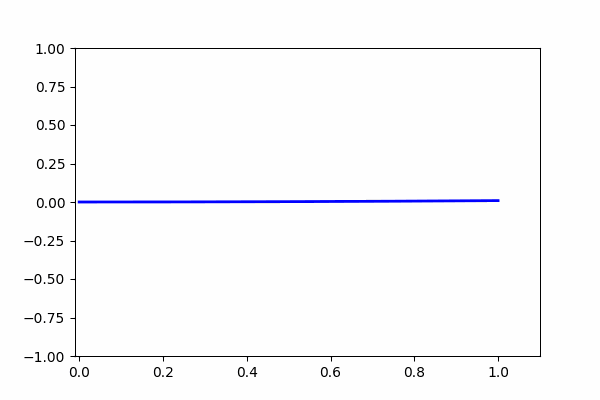

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import glob

# Load all frames (sorted!)
frames = [Image.open(f"/content/images/img{i}.png") for i in range(1, 101)]

# Save as GIF
frames[0].save("sma_animation.gif",
               save_all=True, append_images=frames[1:],
               duration=200, loop=0)  # duration=200 ms per frame

# Show inline
from IPython.display import Image as IPImage
IPImage("sma_animation.gif")